<h1><center>Smart Infrastructure Maintainance</center></h1>

<div style="text-align: center">
    
    Author - Tanay Dwivedi
    University - Indian Institute of Technology Madras
    Current Year - 4th 
    
    Team Name - [Bracket] 
    Theme - Smart Infrastructure Maintainance
    
</div>

# Task 1 - Data Compression

## 1. Setup

Please follow the setup instructions mentioned in each section for successfully running this notebook.

### 1.1 Dependencies

Following packages are required to run this notebook. Please ensure that these are installed in your system. Uncomment the first cell to download using pip.

- os (system package)
- pickle (system package)
- datetime (system package)
- warnings(system package)
- pandas 
- numpy
- matplotlib
- sklearn
- tensorflow

In [1]:
# Uncomment the below cells for installing packages
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install scikit-learn
# !pip install tensorflow

In [2]:
import os
import pickle
import sklearn
import datetime
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from scripts.sap_hackathon import *

warnings.simplefilter(action='ignore')

In [3]:
# A helper function for calculating error
def error(y_true, y_pred):
    error = 0
    for i in range(20):
        error += np.sum(np.abs(np.sum(y_true[:, 3*i:3*(i+1)]**2, axis=1) - np.sum(y_pred[:, 3*i:3*(i+1)]**2, axis=1)))
    return 100 * error / np.sum(y_true**2)

In [4]:
def rmse(y_true, y_pred):
    error = np.sum((np.sum(y_true**2, axis=1) - np.sum(y_pred ** 2, axis=1))**2)
    return error / y_true.shape[0]

### 1.2 Data Directory

Please ensure that the scripts & dataset (both train and test) follows the following directory structure:-

    |-- base_dir
    
        [Code]
        |-- task_1_data_compression_notebook.ipynb (This notebook)
        |-- scripts
            |-- sap_hackathon.py
            
        [Model]
        |-- model
            |-- encoder.pkl
            |-- decoder.pkl
        
        [Train/Test Data]
        |-- LORD-6305-6000-69503
            |-- year=2020
                |-- month=10
                    |-- day=19
                        |-- hour=04
                        |-- ... [All the hours]
                        |-- hour=23
                    |--... [All the Days]
                    |-- day=25
                    
        |-- LORD-6305-6000-69504
            |-- year=2020
                |-- month=10
                    |-- day=19
                        |-- hour=04
                        |-- ... [All the hours]
                        |-- hour=23
                    |--... [All the Days]
                    |-- day=25
        
        |-- ... [All the Sensors]
        
        |-- LORD-6305-6182-92392
            |-- year=2020
                |-- month=10
                    |-- day=19
                        |-- hour=04
                        |-- ... [All the hours]
                        |-- hour=23
                    |--... [All the Days]
                    |-- day=25


1. The data should reside in the structure shown above.
2. The name of the sensors, like LORD-6305-6182-92392 remains the same in test data and train data.
3. Please mention the time period of test data in the list in following cell (User Input).

### User Input

In [5]:
# Year of the test data
test_year = ['2020']   

# Month of the test data
test_month = ['10']

# Date of the test data
test_date = ['19']     

# Time of the test data
test_hour = ['05']     

## 2. Extract, Load, Transform (ELT)

In this section, the data will be loaded <b>according to the time which are listed in the previous cell </b>. Note that 20 dataframes will be loaded, after which they will be concatenated to form a single dataframe containing all the 60 sensor readings given by their time-stamp. 

### 2.1 Transformation

An accelerometer principally measures proper acceleration of the body on which it is installed. Thus the effect of acceleration due gravity would be included in the readings of the accelerometer. Since the orientation of the acceleormeter is not known beforehand, therefore as a first step, we <b>transform the axis of acceleormeters to align with the direction of gravity</b>. This is pictorically represented in the figure below:-

<img src='./images/transformation.PNG' align="center" height="230px">

The coordinate system (x, y, z) is transformed into (u, v, w) such that the 'w'-axis represents the direction of gravity. In the new transformed coordinate system, the mean acceleration on (u, v)- axis will be zero. With this transformation, it can be ensured that the 'w'-axis of all the 20 sensors point in the same direction. However, the the relative orientation of (u, v)-axis between different sensors could not be established.  

After the transformation, the <b>50-th percentile of each sensor from each transformed axis</b>. This ensures that a zero mean signal is obtained which is later used as primary features in our model of data compression.

In [6]:
test_df_list = []
for s, sensor_name in enumerate(sensors):
    temp_df = read_test_data(sensor_name, test_year, test_month, test_date, test_hour, s)
    test_df_list.append(temp_df)
    
# Printing the transformed data for 20-th sensor
display(test_df_list[19])

,_t,x_20,y_20,z_20
0,1603083943234375,3.498033e-09,7.329017e-03,0.000114
1,1603083943250000,-2.405678e-03,7.349223e-03,-0.002394
2,1603083943265625,-2.405678e-03,4.906223e-03,-0.002414
3,1603083943281250,-4.865412e-03,2.020832e-05,-0.002508
4,1603083943296875,2.405706e-03,-2.019520e-05,0.002561
...,...,...,...,...
230395,1603087543406250,5.405626e-05,2.020832e-05,-0.002400
230396,1603087543421875,-2.405678e-03,2.020832e-05,-0.002454
230397,1603087543437500,-2.459731e-03,-2.443005e-03,-0.000020
230398,1603087543453125,3.498033e-09,2.636912e-09,0.000054


In [7]:
# Concatenating into single dataframe
# NOTE - Time stamps will be dropped for which there is atleast one missing data
common_time = estimate_common_time(test_df_list)

test_df = pd.DataFrame(common_time, columns=['_t']).sort_values(by='_t')
for i in range(len(test_df_list)):
    test_df = pd.merge(test_df, test_df_list[i], on='_t', how='left')

print(test_df.shape)

(198881, 61)


## 3. Encoder Model (Data Compression)

The encoder model is saved as './model/encoder.pkl'. This model is essentially <b>sklearn's PCA class object</b> which is saved as pkl. Final results is also summarized at the end of this cell.

For detailed explaination of the model and training steps, please refer to train notebook.

The encoded data is saved as CSV file as './data/encoded_data.csv'.

In [8]:
X = test_df.drop(['_t'], axis=1).to_numpy()

# Loading encoder and transforming to encodings
encoder = pickle.load(open('model/encoder.pkl', mode='rb'))
X_trans = encoder.transform(X)

In [9]:
# Compression Results
print('Original components length = ', X.shape[1])
print('Encoded components length =', X_trans.shape[1])
print('Compression Ratio =', X.shape[1] / X_trans.shape[1])

# Saving the encoded data under './data/encoded_data.csv'
encoded_data = pd.DataFrame(X_trans, columns=['ch' + str(i+1) for i in range(X_trans.shape[1])])
encoded_data = pd.concat([test_df[['_t']], encoded_data], axis=1)

Original components length =  60
Encoded components length = 30
Compression Ratio = 2.0


In [10]:
if not os.path.exists('./data/'):
    os.mkdir('./data/')
    
encoded_data.to_csv('./data/encoded_data.csv', index=False)

## 4. Decoder Model (Data Reconstruction)

The decoder model is saved as './model/decoder.pkl'. This model is essentially <b>sklearn's PCA class object</b> which is saved as pkl. Final results is also summarized at the end of this cell.

For detailed explaination of the model and training steps, please refer to train notebook.

The decoded data is saved as CSV file as './data/decoded_data.csv'.

In [11]:
decoder = pickle.load(open('model/decoder.pkl', mode='rb'))
X_decoded = decoder.inverse_transform(X_trans)

In [12]:
# Saving the decoded data under './data/decoded_data.csv'
decoded_data = pd.DataFrame(X_decoded, columns=test_df.drop(['_t'], axis=1).columns)
decoded_data = pd.concat([test_df[['_t']], decoded_data], axis=1)

In [13]:
df_list=[]
for s in range(1, 21):
    features = ['_t', 'x_' + str(s), 'y_' + str(s), 'z_' + str(s)]
    df_list.append(project_back(decoded_data[features], s))

In [14]:
df_list[1]

,_t,ch1,ch2,ch3
0,1603084186890625,9.819226,-0.010412,0.123305
1,1603084186906250,9.816955,-0.008863,0.121842
2,1603084186921875,9.818844,-0.009375,0.122924
3,1603084186937500,9.816694,-0.009602,0.123168
4,1603084186953125,9.819378,-0.010513,0.121334
...,...,...,...,...
198876,1603087294640625,9.819024,-0.012034,0.121234
198877,1603087294656250,9.819319,-0.010054,0.121423
198878,1603087294671875,9.819719,-0.011433,0.119884
198879,1603087294687500,9.816917,-0.008783,0.121371


In [15]:
# Saving the decoded values as CSV file
for s, sensor_name in enumerate(sensors):
    if not os.path.exists('./data/'):
        os.mkdir('./data/')
    df_list[0].to_csv('./data/' + sensor_name + '.csv', index=False)

## 5. Metric Computation

Meaduring the percentage error due to data compression and reconstruction using the formula given in the problem statement.

In [16]:
print('Error in data reconstruction =', error(X, X_decoded), '%')

Error in data reconstruction = 8.335618939594557 %


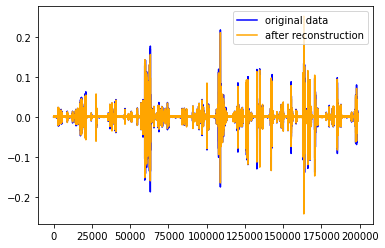

In [17]:
# Visualizing reconstruction for 'x_1'
idx = 12

plt.figure()
plt.plot(X[:, idx], color='blue', label='original data')
plt.plot(X_decoded[:, idx], color='orange', label='after reconstruction')
plt.legend(loc=1)
plt.show()

# Task 2 - Sensor Network Robustness

## 1. Setup

The setup instruction are same as that for the Task 1. Please follow the instruction given in the Task 1 properly to run this Task.

1. The data should reside in the directory structure shown above.
2. The name of the sensors, like LORD-6305-6182-92392 remains the same in test data and train data.
3. Please mention the time period of test data in the list in following cell (User Input).

### User Input:

In [18]:
# Year of the test data
test_year = ['2020']   

# Month of the test data
test_month = ['10']

# Date of the test data
test_date = ['19']     

# Time of the test data
test_hour = ['05']

# The sensor on which anomaly has to be checked
test_sensor = 'LORD-6305-6000-69503'

## 2. Extract, Load, Transform (ELT)

The preprocessing steps performed in this task are essentially the same as that in Task 1. Please refer to Section 2 of task 1 for a detailed overview.

In [19]:
test_df_list = []
skip_sensor = sensors.index(test_sensor)
for s, sensor_name in enumerate(sensors):
    if s != skip_sensor:
        temp_df = read_test_data(sensor_name, test_year, test_month, test_date, test_hour, s)
        test_df_list.append(temp_df)

# Printing the transformed data for 20-th sensor
display(test_df_list[0])

,_t,x_2,y_2,z_2
0,1603083724031250,-3.901076e-12,2.447351e-03,0.000030
1,1603083724046875,-3.901076e-12,1.799510e-10,0.000000
2,1603083724062500,-3.901076e-12,1.799510e-10,0.000000
3,1603083724078125,-2.304381e-06,2.477745e-03,-0.002424
4,1603083724093750,-2.304381e-06,3.039501e-05,-0.002455
...,...,...,...,...
230395,1603087323953125,-7.329784e-03,9.118466e-05,-0.007357
230396,1603087323968750,-4.881913e-03,-2.447358e-03,-0.000026
230397,1603087323984375,-9.752305e-03,-2.599332e-03,0.012252
230398,1603087324000000,4.877304e-03,6.078984e-05,-0.004914


In [20]:
# Concatenating into single dataframe
# NOTE - Time stamps will be dropped for which there is atleast one missing data
common_time = estimate_common_time(test_df_list)

test_df = pd.DataFrame(common_time, columns=['_t']).sort_values(by='_t')
for i in range(len(test_df_list)):
    test_df = pd.merge(test_df, test_df_list[i], on='_t', how='left')

print(test_df.shape)

(198881, 58)


## 3. Model - Multilayer Perceptron (MLP)

The final predictions are saved under 'data/predictions.csv'. These can be used by the user to compare the data for test case.

In [21]:
X = test_df.drop(['_t'], axis=1).to_numpy()

model = tf.keras.models.load_model('model/model_task_' + str(skip_sensor+1), compile=False)
X_predicted = model.predict(X)

In [22]:
pred_df = test_df[['_t']]
pred_df = pd.concat([pred_df, pd.DataFrame(
    X_predicted, columns=['x_' + str(skip_sensor+1), 'y_' + str(skip_sensor+1), 'z_' + str(skip_sensor+1)])], axis=1)
decoded_df = project_back(pred_df, skip_sensor + 1)
display(decoded_df)

,_t,ch1,ch2,ch3
0,1603084186890625,9.822381,0.159587,0.127127
1,1603084186906250,9.816688,0.157533,0.125269
2,1603084186921875,9.817215,0.159864,0.127284
3,1603084186937500,9.813652,0.156323,0.125373
4,1603084186953125,9.820212,0.157496,0.125879
...,...,...,...,...
198876,1603087294640625,9.817586,0.157222,0.127248
198877,1603087294656250,9.817419,0.155053,0.125807
198878,1603087294671875,9.815001,0.157422,0.124537
198879,1603087294687500,9.817573,0.160745,0.124468


In [23]:
if not os.path.exists('./data/'):
    os.mkdir('./data/')
    
decoded_df.to_csv('./data/predictions_' + str(skip_sensor + 1) + '.csv', index=False)

## 4. Result Analysis

In [24]:
# Displaying actual ground truth
ground_truth = project_back(read_test_data(test_sensor, test_year, test_month, test_date, 
                                           test_hour, skip_sensor), skip_sensor+1)

ground_truth = ground_truth[ground_truth['_t'].isin(common_time)].reset_index(drop=True)
display(ground_truth)

,_t,ch1,ch2,ch3
0,1603084186890625,9.817719,0.157688,0.126001
1,1603084186906250,9.817719,0.157688,0.126001
2,1603084186921875,9.817719,0.157688,0.126001
3,1603084186937500,9.817719,0.157688,0.126001
4,1603084186953125,9.817719,0.160139,0.126001
...,...,...,...,...
198876,1603087294640625,9.817719,0.155237,0.126001
198877,1603087294656250,9.817719,0.157688,0.126001
198878,1603087294671875,9.817719,0.157688,0.126001
198879,1603087294687500,9.817719,0.157688,0.123554


In [25]:
# Calculating mean squared Error
y_true = ground_truth.drop(['_t'], axis=1).to_numpy()
y_pred = decoded_df.drop(['_t'], axis=1).to_numpy()

print('Mean Squared Error =', rmse(y_true, y_pred))

Mean Squared Error = 0.0915703236221832


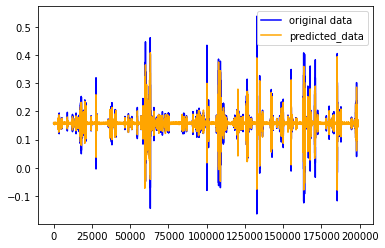

In [26]:
# Visualizing reconstruction for 'x_1'
idx = 1

plt.figure()
plt.plot(y_true[:, idx], color='blue', label='original data')
plt.plot(y_pred[:, idx], color='orange', label='predicted_data')
plt.legend(loc=1)
plt.show()